Custom Model (Final)

Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay

import matplotlib.ticker as mtick
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

sns.set()

import pickle

import notebook_util as n_util
from notebook_util import *

Comet ML setup

In [2]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="UGYDiy3HENiE7Y3dqoMAVIgG2",
    project_name="custom-models",
    workspace="ift6758a-a22-g3-projet",
)

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": 0.0001,
    "batch_size": 50,
    "num_epochs": 2,
    "criterion": "BinaryCrossEntropy",
    "optimizer": "Adam",
}
experiment.log_parameters(hyper_params)


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758a-a22-g3-projet/custom-models/e2125728645b445c82dba97d850b9d99



Prep Data

In [3]:
df_filtered = prep_data()

df_filtered = prep_dummie(df_filtered)

c:\Users\Bei Ning\Documents\GitHub\ift6758-a22-g3-projet\notebooks\notebook_util.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
c:\Users\Bei Ning\Documents\GitHub\ift6758-a22-g3-projet\notebooks\notebook_util.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['strength'] = df_filtered['strength'].fillna('Even')


Split Train & Validation Dataset

In [4]:
train, test = train_test_split(df_filtered, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(206814, 36)
(101864, 36)


In [5]:
x_train = train[n_util.feature]

y_train = train['isGoal']

x_train, y_train = RandomOverSampler().fit_resample(x_train, y_train)

x_test = test[n_util.feature]

y_test = test['isGoal']

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(375514, 35)
(375514,)
(101864, 35)
(101864,)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = F.sigmoid(x)
        
        return x
    
net = Net()

In [8]:
batch_size = hyper_params["batch_size"]
num_epochs = hyper_params["num_epochs"]
learning_rate = hyper_params["learning_rate"]
batch_no = len(x_train) // batch_size

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [9]:
x_train_t = torch.tensor(x_train.to_numpy(dtype=np.float32), dtype = torch.float32)
y_train_t = torch.tensor(y_train.values, dtype = torch.float32)

x_test_t = torch.tensor(x_test.to_numpy(dtype=np.float32), dtype = torch.float32)
y_test_t = torch.tensor(y_test.values, dtype = torch.float32)

In [10]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train_t, y_train_t = shuffle(x_train_t, y_train_t)
    loss_sum = 0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train_t[start:end]))
        y_var = Variable(torch.FloatTensor(y_train_t[start:end]))
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var[:,None])
        loss.backward()
        loss_sum = loss_sum + loss
        #print(loss)
        optimizer.step()
    print(loss_sum/batch_no)

Epoch 1


c:\Anaconda\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.6625, grad_fn=<DivBackward0>)
tensor(0.5879, grad_fn=<DivBackward0>)


In [11]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x_test_t), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values = torch.round(result[:, 0])

num_right = np.sum(values.data.numpy().astype(int) == y_test)
print('Num Right', num_right)
print('Accuracy {:.2f}'.format(num_right / len(y_test_t)))

Num Right 90083
Accuracy 0.88


In [12]:
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryF1Score

target_m = torch.tensor(y_test.to_numpy()).to(torch.int)
pred_m = torch.tensor(values).to(torch.int)

confmat = ConfusionMatrix(num_classes=2)
confmat(target_m, pred_m)

C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_16912\1599096580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_m = torch.tensor(values).to(torch.int)


tensor([[87868,  6995],
        [ 4786,  2215]])

In [13]:
metric = BinaryF1Score()
print('F1 Pytorch')
print(metric(result[:, 0], target_m).item())
from sklearn.metrics import f1_score
f1 = f1_score(target_m.numpy(), values.numpy().astype(int), average='macro')
print('F1 Sklearn Macro')
print(f1)

F1 Pytorch
0.27327123284339905
F1 Sklearn Macro
0.6052224659161591


In [14]:
fpr, tpr, threshold = metrics.roc_curve(y_test, result[:, 0].numpy())
roc_auc = metrics.auc(fpr, tpr)

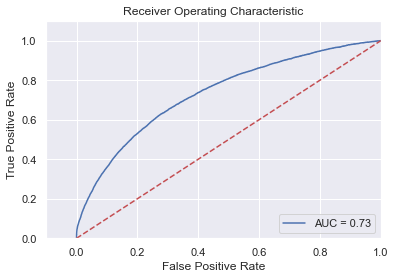

In [15]:
show_roc(fpr, tpr, roc_auc)

In [16]:
y_test_pred = values.numpy().astype(int)
score_prob = result[:, 0].numpy()

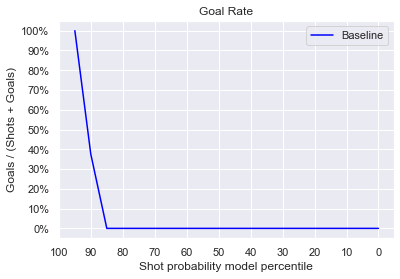

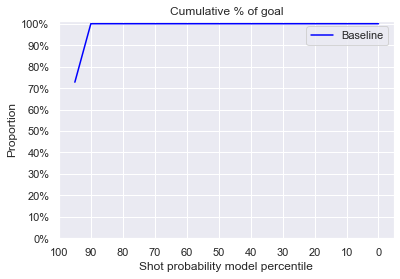

In [17]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_test_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

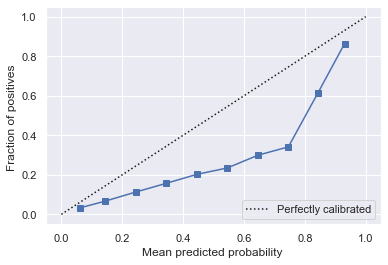

In [18]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

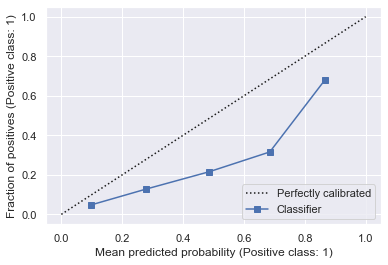

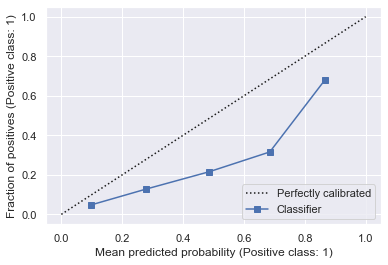

In [19]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob).plot()
plt.show()

In [20]:
pickle.dump(net, open("../models/MLP1.sav", 'wb'))
experiment.log_model("MLP1", "../models/MLP1.sav")
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758a-a22-g3-projet/custom-models/e2125728645b445c82dba97d850b9d99
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1502] : (0.39642852544784546, 1.4735538959503174)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 50
COMET INFO:     criterion     : BinaryCrossEntropy
COMET INFO:     learning_rate : 0.0001
COMET INFO:     num_epochs    : 2
COMET INFO:     optimizer     : Adam
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncomp